In [169]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor,\
                             StackingRegressor, VotingRegressor

from sklearn.svm import LinearSVR, SVR
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from scipy.stats import normaltest
import sklearn.metrics


import statsmodels.api as sm 
#import pylab as py 

from scipy.stats import boxcox
from scipy.special import inv_boxcox
#import autosklearn.regression
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

#import manufacturing as mn
import visual, analysis

%matplotlib
ROOT_DIR = './'
print("Ready!")

Hi
Hi from Visual!
Using matplotlib backend: Qt5Agg
Ready!


In [50]:
def round_to_hour(dt):
    if dt.minute > 30:#date.replace(minute = 0, hour = 0)
        if dt.hour == 23:
            return dt.replace(minute = 0, hour = 0, second = 0)
        else:
            return dt.replace(minute = 0, hour = dt.hour + 1, second = 0) 
    else:
        return dt.replace(minute = 0, second = 0)
    
def round_dt_to_10min(dt):
    try:
        tmp_min = int(str(int(dt.minute/10)) + '0') if dt.minute/10 > 1 else int(dt.minute)
    except ValueError as e:
        print(e, dt)
        return 'Null'
    if (dt.minute - tmp_min) < 5:
        return dt.replace(minute = tmp_min, second = 0)#если разница меньше 5 минут
    else: 
        try:
            if dt.hour == 23 and tmp_min == 50:
                return dt.replace(day = dt.day + 1 ,minute = 0, second = 0, hour = 0) #для 23:55+ переход на некст день
        except ValueError:
            try:
                return dt.replace(day = 1 ,minute = 0, second = 0, hour = 0, month = dt.month + 1) #для 23:55+ переход на некст месяц
            except ValueError:
                return dt.replace(day = 1 ,minute = 0, second = 0, hour = 0, month = 1, year = dt.year + 1)
        if tmp_min == 50:
            return dt.replace(minute = 0, second = 0, hour = dt.hour + 1)#для НН:55+ добавляем час
        return dt.replace(minute = tmp_min + 10, second = 0)
    
def round_to_half_hour(dt):
    #q = int(dt.minute/15)
    #print(q, dt)
    td = timedelta(hours = 1)
    if dt.minute <= 15:
        return dt.replace(minute = 0)
    if dt.minute > 15 & dt.minute < 45:
        return dt.replace(minute = 30)
    if dt.minute >= 45:
        return dt.replace(minute = 0) + td

def is_norm(s):
    #Тест д'Агостино на K ^ 2 
    #if p < a:  # null hypothesis: x comes from a normal distribution
    a = 0.05
    sts, p = normaltest(s)
    if p > a:
        #print('+Sample looks Gaussian (fail to reject H0)')
        return True, p
    else:
        #print('-Sample does not look Gaussian (reject H0)',p)
        return False, p

In [6]:

def prepare_mes_df(mes_df):
    mes_df = mes_df.replace('Null', np.nan)
    mes_df['34апп.сумма.3нитка'] = mes_df['DK14_SKD_Deg_003.F3_1'].astype(float) + mes_df['DK14_SKD_Deg_003.F3_2'].astype(float) + mes_df['DK14_SKD_Deg_003.FRC3009'].astype(float)
    mes_df['34апп.сумма.4нитка'] = mes_df['DK14_SKD_Deg_004.F3_1'].astype(float) + mes_df['DK14_SKD_Deg_004.F3_2'].astype(float) + mes_df['DK14_SKD_Deg_004.FR3012'].astype(float)
    mes_df['34апп.сумма.5нитка'] = mes_df['DK14_SKD_Deg_005.F3_1'].astype(float) + mes_df['DK14_SKD_Deg_005.F3_2'].astype(float) + mes_df['DK14_SKD_Deg_005.FR3015'].astype(float)

    #подача сухого полимера
    mes_df['DK14_SKD_Deg_003.F1'] /=  10
    mes_df['DK14_SKD_Deg_004.F1'] /= 10
    mes_df['DK14_SKD_Deg_005.F1'] /= 10

    mes_df['Суммарная подача пара на 3 нитку, т/час'] = mes_df['DK14_SKD_Deg_003.F3_1'].astype(float) + mes_df['DK14_SKD_Deg_003.F3_2'].astype(float) + mes_df['DK14_SKD_Deg_003.FRC3009'].astype(float) + mes_df['DK14_SKD_Deg_003.F3_3'].astype(float)
    mes_df['Суммарная подача пара на 4 нитку, т/час'] = mes_df['DK14_SKD_Deg_004.F3_1'].astype(float) + mes_df['DK14_SKD_Deg_004.F3_2'].astype(float) + mes_df['DK14_SKD_Deg_004.FR3012'].astype(float) + mes_df['DK14_SKD_Deg_004.F3_3'].astype(float)
    mes_df['Суммарная подача пара на 5 нитку, т/час'] = mes_df['DK14_SKD_Deg_005.F3_1'].astype(float) + mes_df['DK14_SKD_Deg_005.F3_2'].astype(float) + mes_df['DK14_SKD_Deg_005.FR3015'].astype(float) + mes_df['DK14_SKD_Deg_005.F3_3'].astype(float)

    formula = 'пар/полимер, ед.изм = ГКал\т'
    mes_df['34апп.удел.сумма.3нитка'] = ((mes_df['DK14_SKD_Deg_003.F3_1'].astype(float) + mes_df['DK14_SKD_Deg_003.F3_2'].astype(float) + mes_df['DK14_SKD_Deg_003.FRC3009'].astype(float)))*0.67/mes_df['DK14_SKD_Deg_003.F1'].astype(float)
    mes_df['34апп.удел.сумма.4нитка'] = ((mes_df['DK14_SKD_Deg_004.F3_1'].astype(float) + mes_df['DK14_SKD_Deg_004.F3_2'].astype(float) + mes_df['DK14_SKD_Deg_004.FR3012'].astype(float)))*0.67/mes_df['DK14_SKD_Deg_004.F1'].astype(float)
    mes_df['34апп.удел.сумма.5нитка'] = ((mes_df['DK14_SKD_Deg_005.F3_1'].astype(float) + mes_df['DK14_SKD_Deg_005.F3_2'].astype(float) + mes_df['DK14_SKD_Deg_005.FR3015'].astype(float)))*0.67/mes_df['DK14_SKD_Deg_005.F1'].astype(float)
    mes_df['удел.сумм.3нитка'] = (mes_df['Суммарная подача пара на 3 нитку, т/час'].astype(float))*0.67/mes_df['DK14_SKD_Deg_003.F1'].astype(float)
    mes_df['удел.сумм.4нитка'] = (mes_df['Суммарная подача пара на 4 нитку, т/час'].astype(float))*0.67/mes_df['DK14_SKD_Deg_004.F1'].astype(float)
    mes_df['удел.сумм.5нитка'] = (mes_df['Суммарная подача пара на 5 нитку, т/час'].astype(float))*0.67/mes_df['DK14_SKD_Deg_005.F1'].astype(float)
    mes_df['120апп.удел.3нитка'] = (mes_df['DK14_SKD_Deg_003.F3_3'].astype(float))*0.67/mes_df['DK14_SKD_Deg_003.F1'].astype(float)
    mes_df['120апп.удел.4нитка'] = (mes_df['DK14_SKD_Deg_004.F3_3'].astype(float))*0.67/mes_df['DK14_SKD_Deg_004.F1'].astype(float)
    mes_df['120апп.удел.5нитка'] = (mes_df['DK14_SKD_Deg_005.F3_3'].astype(float))*0.67/mes_df['DK14_SKD_Deg_005.F1'].astype(float)

    
    #Сдвиг во времени от дегазаторов до места взячи анализа
    mes_df['Дата и время'] = mes_df['Дата и время'].astype('datetime64[ns]') - timedelta(minutes = 90)
    
    
    return mes_df

def prepare_lims_df(lims_df):
    try:
        lims_df = lims_df.drop(columns = ['Unnamed: 3','Unnamed: 4','Массовая доля антиоксиданта Агидол-2, Проценты относител.','Unnamed: 6','Unnamed: 8','Unnamed: 9','Unnamed: 11','Unnamed: 12', 'Unnamed: 13','Примечание','Место отбора', "Номер партии"]).rename(columns = {'Дата и время отбора':'Дата и время'}).iloc[:,:3]
    except KeyError:
        lims_df = lims_df.drop(columns = ['Unnamed: 3','Unnamed: 4','Unnamed: 6','Unnamed: 8','Unnamed: 9','Примечание','Место отбора', "Номер партии"]).rename(columns = {'Дата и время отбора':'Дата и время'}).iloc[:,:3]
    lims_df['Массовая доля тримеров, %'] = (lims_df['Массовая доля тримеров, %']/1000).astype(float)
    lims_df['Массовая доля углеводородов, %'] = (lims_df['Массовая доля углеводородов, %']/100).astype(float)
    lims_df['Дата и время'] = lims_df['Дата и время'].astype('datetime64[ns]').apply(round_to_half_hour)
    
    #tdelta = timedelta(minutes = 30)
    #lims_df['Дата и время'] = lims_df['Дата и время'] + tdelta
    return lims_df

def make_final_df(mes_df, lims_df):
    fin_df = mes_df.merge(lims_df, how = 'left', on = 'Дата и время').sort_values(by='Дата и время')
    #

    try:
        fin_df.to_excel('fin_df.xlsx')
    except pd.FileCreateError as fce:
        print(fce)
    return fin_df


In [7]:
lims_data = pd.read_excel(os.path.join(ROOT_DIR, 'Сводный журнал результатов анализов за период ЦЗЛ ПП ПБК.xlsx'),sheet_name = 'Лист1',thousands = ',')
mes_data = pd.read_excel(os.path.join(ROOT_DIR, 'скд.xlsx'),sheet_name = 'скд').drop(columns = [ 'wwRetrievalMode','Дата и время.1'])

addition_data = pd.read_excel("C:\\Users\\bobca\\WorkData\\SKD_DEG\\skd deg new data\\Лист Microsoft Excel.xlsx",sheet_name = 'Лист1').replace('Null', np.nan).drop(columns = ['wwRetrievalMode'])
addition_data['Дата и время'] = addition_data['Дата и время'].astype('datetime64[ns]') - timedelta(minutes = 90)

mes_df1 = prepare_mes_df(mes_data)
lims_df1 = prepare_lims_df(lims_data)
mes_df1 = mes_df1.merge(addition_data, how = 'left', on = 'Дата и время')
final_df1 = make_final_df(mes_df1, lims_df1)


lims_new_data = pd.read_excel("C:\\Users\\bobca\\WorkData\\SKD_DEG\\skd deg new data\\Сводный журнал результатов c 18 до 19,5.xlsx",sheet_name = 'Лист2',thousands = ',')
mes_new_data = pd.read_excel("C:\\Users\\bobca\\WorkData\\SKD_DEG\\skd deg new data\\skd18-195_new.xlsx",sheet_name = 'skd18-195_new')
mes_df2 = prepare_mes_df(mes_new_data)
lims_df2 = prepare_lims_df(lims_new_data)
final_df2 = make_final_df(mes_df2, lims_df2)

fin_df = final_df1.append(final_df2)
fin_df
fin_df

,120апп.удел.3нитка,120апп.удел.4нитка,120апп.удел.5нитка,34апп.сумма.3нитка,34апп.сумма.4нитка,34апп.сумма.5нитка,34апп.удел.сумма.3нитка,34апп.удел.сумма.4нитка,34апп.удел.сумма.5нитка,DK14_SKD_Deg_003.F1,...,VR010104EKSTEAM_SOUTH.LHA,Дата и время,"Массовая доля тримеров, %","Массовая доля углеводородов, %","Суммарная подача пара на 3 нитку, т/час","Суммарная подача пара на 4 нитку, т/час","Суммарная подача пара на 5 нитку, т/час",удел.сумм.3нитка,удел.сумм.4нитка,удел.сумм.5нитка
0,0.0,1.608311,1.560061,-0.048965,25.297186,26.960779,-3.957034e+15,2.806579,3.000372,8.290680e-18,...,NaN,2019-05-31 22:30:00,NaN,NaN,-0.048965,39.793751,40.979198,-3.957034e+15,4.414891,4.560434
1,0.0,1.609767,1.565473,-0.052734,25.319632,27.031043,-4.261662e+15,2.814135,3.024005,8.290680e-18,...,NaN,2019-05-31 23:00:00,NaN,NaN,-0.052734,39.803199,41.024525,-4.261662e+15,4.423903,4.589477
2,0.0,1.612604,1.559316,-0.051353,25.333811,27.007740,-4.150033e+15,2.820297,3.007926,8.290680e-18,...,NaN,2019-05-31 23:30:00,NaN,NaN,-0.051353,39.819309,41.008613,-4.150033e+15,4.432902,4.567242
3,0.0,1.611580,1.560888,-0.048707,25.338701,27.024299,-3.936194e+15,2.813271,3.018050,8.290680e-18,...,NaN,2019-06-01 00:00:00,NaN,NaN,-0.048707,39.853957,41.000843,-3.936194e+15,4.424852,4.578938
4,0.0,1.612793,1.556335,-0.050377,25.304534,27.010660,-4.071182e+15,2.815966,3.010917,8.290680e-18,...,NaN,2019-06-01 00:30:00,NaN,NaN,-0.050377,39.797246,40.972400,-4.071182e+15,4.428759,4.567251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24769,0.0,1.612468,1.553787,-0.051619,25.418296,26.900272,-4.171481e+15,2.825700,2.989259,8.290680e-18,...,NaN,2019-05-31 20:30:00,NaN,NaN,-0.051619,39.923092,40.882761,-4.171481e+15,4.438168,4.543046
24770,0.0,1.610821,1.557292,-0.051103,25.450527,26.982763,-4.129798e+15,2.827195,3.004411,8.290680e-18,...,NaN,2019-05-31 21:00:00,NaN,NaN,-0.051103,39.951203,40.968883,-4.129798e+15,4.438015,4.561703
24771,0.0,1.615200,1.558635,-0.051501,25.304810,26.960389,-4.161999e+15,2.818104,2.996399,8.290680e-18,...,NaN,2019-05-31 21:30:00,NaN,NaN,-0.051501,39.808294,40.984361,-4.161999e+15,4.433304,4.555035
24772,0.0,1.615843,1.548354,-0.049309,25.234069,26.985618,-3.984805e+15,2.811615,2.990540,8.290680e-18,...,NaN,2019-05-31 22:00:00,NaN,NaN,-0.049309,39.736163,40.957440,-3.984805e+15,4.427458,4.538894


In [8]:
#Для drop'a нитки
nit3 = ['DK14_SKD_Deg_003.F1',
 'DK14_SKD_Deg_003.F1_M',
 'DK14_SKD_Deg_003.F2_1',
 'DK14_SKD_Deg_003.F2_2',
 'DK14_SKD_Deg_003.F3_1',
 'DK14_SKD_Deg_003.F3_1.IsOverheat',
 'DK14_SKD_Deg_003.F3_1.T_sat',
 'DK14_SKD_Deg_003.F3_2',
 'DK14_SKD_Deg_003.F3_2.IsOverheat',
 'DK14_SKD_Deg_003.F3_2.T_sat',
 'DK14_SKD_Deg_003.F3_3',
 'DK14_SKD_Deg_003.F4',
 'DK14_SKD_Deg_003.F5',
 'DK14_SKD_Deg_003.F6',
 'DK14_SKD_Deg_003.F7_1',
 'DK14_SKD_Deg_003.F7_2',
 'DK14_SKD_Deg_003.FRC3009',
 'DK14_SKD_Deg_003.FRC3009.IsOverheat',
 'DK14_SKD_Deg_003.FRC3009.T_sat',
 'DK14_SKD_Deg_003.I1',
 'DK14_SKD_Deg_003.I2',
 'DK14_SKD_Deg_003.L1',
 'DK14_SKD_Deg_003.L1_1',
 'DK14_SKD_Deg_003.L1_2',
 'DK14_SKD_Deg_003.L2',
 'DK14_SKD_Deg_003.L2_1',
 'DK14_SKD_Deg_003.L2_2',
 'DK14_SKD_Deg_003.P1',
 'DK14_SKD_Deg_003.P2',
 'DK14_SKD_Deg_003.P2_1',
 'DK14_SKD_Deg_003.Q2',
 'DK14_SKD_Deg_003.Q2_2',
 'DK14_SKD_Deg_003.Q3_1_2',
 'DK14_SKD_Deg_003.Q3_2',
 'DK14_SKD_Deg_003.Q3_3',
 'DK14_SKD_Deg_003.Q4',
 'DK14_SKD_Deg_003.Q5',
 'DK14_SKD_Deg_003.Q6',
 'DK14_SKD_Deg_003.State1',
 'DK14_SKD_Deg_003.State2',
 'DK14_SKD_Deg_003.T1',
 'DK14_SKD_Deg_003.T2',
 'DK14_SKD_Deg_003.T3',
 'DK14_SKD_Deg_003.T4',
 'DK14_SKD_Deg_003.TT100',
 'DK14_SKD_Deg_003.TT101',
 '34апп.сумма.3нитка',
 'Суммарная подача пара на 3 нитку, т/час',
 '34апп.удел.сумма.3нитка',
 'удел.сумм.3нитка',
 '120апп.удел.3нитка',
 'DK14_Shop.REZIM_3N']


nit4 = [ 'DK14_SKD_Deg_004.F1',
 'DK14_SKD_Deg_004.F1_M',
 'DK14_SKD_Deg_004.F2_1',
 'DK14_SKD_Deg_004.F2_2',
 'DK14_SKD_Deg_004.F3_1',
 'DK14_SKD_Deg_004.F3_1.IsOverheat',
 'DK14_SKD_Deg_004.F3_1.T_sat',
 'DK14_SKD_Deg_004.F3_2',
 'DK14_SKD_Deg_004.F3_2.IsOverheat',
 'DK14_SKD_Deg_004.F3_2.T_sat',
 'DK14_SKD_Deg_004.F3_3',
 'DK14_SKD_Deg_004.F3_3.IsOverheat',
 'DK14_SKD_Deg_004.F3_3.T_sat',
 'DK14_SKD_Deg_004.F4',
 'DK14_SKD_Deg_004.F5',
 'DK14_SKD_Deg_004.F6',
 'DK14_SKD_Deg_004.F7_1',
 'DK14_SKD_Deg_004.F7_2',
 'DK14_SKD_Deg_004.FR3012',
 'DK14_SKD_Deg_004.FR3012.IsOverheat',
 'DK14_SKD_Deg_004.FR3012.T_sat',
 'DK14_SKD_Deg_004.FRC3012',
 'DK14_SKD_Deg_004.I1',
 'DK14_SKD_Deg_004.I2',
 'DK14_SKD_Deg_004.L1',
 'DK14_SKD_Deg_004.L1_1',
 'DK14_SKD_Deg_004.L1_2',
 'DK14_SKD_Deg_004.L2',
 'DK14_SKD_Deg_004.L2_1',
 'DK14_SKD_Deg_004.L2_2',
 'DK14_SKD_Deg_004.P1',
 'DK14_SKD_Deg_004.P2',
 'DK14_SKD_Deg_004.P2_1',
 'DK14_SKD_Deg_004.Q2',
 'DK14_SKD_Deg_004.Q2_2',
 'DK14_SKD_Deg_004.Q3_1_2',
 'DK14_SKD_Deg_004.Q3_2',
 'DK14_SKD_Deg_004.Q3_3',
 'DK14_SKD_Deg_004.Q4',
 'DK14_SKD_Deg_004.Q5',
 'DK14_SKD_Deg_004.Q6',
 'DK14_SKD_Deg_004.State1',
 'DK14_SKD_Deg_004.State2',
 'DK14_SKD_Deg_004.T1',
 'DK14_SKD_Deg_004.T2',
 'DK14_SKD_Deg_004.T3',
 'DK14_SKD_Deg_004.T4',
 '34апп.сумма.4нитка',
 'Суммарная подача пара на 4 нитку, т/час',
 '34апп.удел.сумма.4нитка',
 'удел.сумм.4нитка',
 '120апп.удел.4нитка']

nit5 = [ 'DK14_SKD_Deg_005.F1',
 'DK14_SKD_Deg_005.F1.8H',
 'DK14_SKD_Deg_005.F1_M',
 'DK14_SKD_Deg_005.F2_1',
 'DK14_SKD_Deg_005.F2_2',
 'DK14_SKD_Deg_005.F3_1',
 'DK14_SKD_Deg_005.F3_1.IsOverheat',
 'DK14_SKD_Deg_005.F3_1.T_sat',
 'DK14_SKD_Deg_005.F3_2',
 'DK14_SKD_Deg_005.F3_2.IsOverheat',
 'DK14_SKD_Deg_005.F3_2.T_sat',
 'DK14_SKD_Deg_005.F3_3',
 'DK14_SKD_Deg_005.F3_3.IsOverheat',
 'DK14_SKD_Deg_005.F3_3.T_sat',
 'DK14_SKD_Deg_005.F4',
 'DK14_SKD_Deg_005.F5',
 'DK14_SKD_Deg_005.F6',
 'DK14_SKD_Deg_005.F7_1',
 'DK14_SKD_Deg_005.F7_2',
 'DK14_SKD_Deg_005.FR3015',
 'DK14_SKD_Deg_005.FR3015.IsOverheat',
 'DK14_SKD_Deg_005.FR3015.T_sat',
 'DK14_SKD_Deg_005.FRC3015',
 'DK14_SKD_Deg_005.I1',
 'DK14_SKD_Deg_005.I2',#Ток мешалки?
 'DK14_SKD_Deg_005.L1',
 'DK14_SKD_Deg_005.L1_1',
 'DK14_SKD_Deg_005.L1_2',
 'DK14_SKD_Deg_005.L2',
 'DK14_SKD_Deg_005.L2_1',
 'DK14_SKD_Deg_005.L2_2',
 'DK14_SKD_Deg_005.P1',
 'DK14_SKD_Deg_005.P2',
 'DK14_SKD_Deg_005.P2_1',
 'DK14_SKD_Deg_005.Q2',
 'DK14_SKD_Deg_005.Q2_2',
 'DK14_SKD_Deg_005.Q3_1_2',
 'DK14_SKD_Deg_005.Q3_2',
 'DK14_SKD_Deg_005.Q3_3',
 'DK14_SKD_Deg_005.Q4',
 'DK14_SKD_Deg_005.Q5',
 'DK14_SKD_Deg_005.Q6',
 'DK14_SKD_Deg_005.State1',
 'DK14_SKD_Deg_005.State2',
 'DK14_SKD_Deg_005.T1',
 'DK14_SKD_Deg_005.T2',
 'DK14_SKD_Deg_005.T3',
 'DK14_SKD_Deg_005.T4',
 'DK14_SKD_Deg_005.TR103_1',
 'DK14_SKD_Deg_005.TR103_2',
 '34апп.сумма.5нитка',
 'Суммарная подача пара на 5 нитку, т/час',
 '34апп.удел.сумма.5нитка',
 'удел.сумм.5нитка',
 '120апп.удел.5нитка']
print(len(nit5), len(nit4), len(nit3))

55 52 52


In [126]:
#FOR ECONS
#print(fin_df.columns.to_list())


#pandas_profiling.ProfileReport(df = nitka_3_df.drop(columns = 'Дата и время')).to_file('3.html')

nitka_3_df = fin_df[[
                    'DK14_SKD_Deg_003.T1','DK14_SKD_Deg_003.T2',
                    'DK14_SKD_Deg_003.P1','DK14_SKD_Deg_003.P2',
                    'DK14_SKD_Deg_003.F1','Дата и время',
                    'Суммарная подача пара на 3 нитку, т/час',
                    'удел.сумм.3нитка','Массовая доля углеводородов, %'
                   ]][\
                       (fin_df['DK14_SKD_Deg_003.F1'] > 1)
                     & (fin_df['Суммарная подача пара на 3 нитку, т/час'] > 5)
                     & (fin_df['34апп.удел.сумма.3нитка'] < 8)
                     & (fin_df['удел.сумм.3нитка'] < 6.5)
                     & (fin_df['DK14_SKD_Deg_003.T1'] > 85)
                     & (fin_df['DK14_SKD_Deg_003.T1'] < 115)
                     & (fin_df['DK14_SKD_Deg_003.T2'] > 100)
                     & (fin_df['DK14_SKD_Deg_003.T2'] < 130)
                     & (fin_df['DK14_Shop.REZIM_3N'] == 0)
                     & (fin_df['Дата и время'] > datetime(2020,1,1,0,0))\
                    ].reset_index().drop(columns = 'index')

#pandas_profiling.ProfileReport(df = nitka_3_df.drop(columns = 'Дата и время')).to_file('3.html')


nitka_4_df = fin_df[[
                    'DK14_SKD_Deg_004.T1','DK14_SKD_Deg_004.T2',
                    'DK14_SKD_Deg_004.P1','DK14_SKD_Deg_004.P2',
                    'DK14_SKD_Deg_004.F1','Дата и время',
                    'Суммарная подача пара на 4 нитку, т/час',
                    'удел.сумм.4нитка','Массовая доля углеводородов, %'
                   ]][\
                       (fin_df['DK14_SKD_Deg_004.F1'] > 1)
                     & (fin_df['Суммарная подача пара на 4 нитку, т/час'] > 5)
                     & (fin_df['34апп.удел.сумма.4нитка'] < 8)
                     & (fin_df['удел.сумм.4нитка'] < 6.5)
                     & (fin_df['DK14_SKD_Deg_004.T2'] > 90)
                     & (fin_df['DK14_SKD_Deg_004.T2'] < 130)
                     & (fin_df['DK14_SKD_Deg_004.T1'] > 85)
                     & (fin_df['DK14_SKD_Deg_004.T1'] < 115)
                     #& (fin_df['DK14_SKD_Deg_004.P1'] > 0.15)
                     #& (fin_df['DK14_SKD_Deg_004.P1'] < 0.35)
                     & (fin_df['Дата и время'] > datetime(2020,1,1,0,0))\
                    ].reset_index().drop(columns = 'index')

#pandas_profiling.ProfileReport(df = nitka_4_df.drop(columns = 'Дата и время')).to_file('4.html')

nitka_5_df = fin_df[[
                    'DK14_SKD_Deg_005.T1','DK14_SKD_Deg_005.T2',
                    'DK14_SKD_Deg_005.P1','DK14_SKD_Deg_005.P2',
                    'DK14_SKD_Deg_005.F1','Дата и время',
                    'Суммарная подача пара на 5 нитку, т/час',
                    'удел.сумм.5нитка','Массовая доля углеводородов, %'
                   ]][  (fin_df['DK14_SKD_Deg_005.F1'] > 1)
                     & (fin_df['Суммарная подача пара на 5 нитку, т/час'] > 5)
                     & (fin_df['34апп.удел.сумма.5нитка'] < 8)
                     & (fin_df['удел.сумм.5нитка'] < 6.5)
                     & (fin_df['DK14_SKD_Deg_005.T2'] < 130)
                     & (fin_df['DK14_SKD_Deg_005.T2'] > 100)
                     & (fin_df['DK14_SKD_Deg_005.T1'] > 85)
                     & (fin_df['DK14_SKD_Deg_005.T1'] < 115)
                     & (fin_df['Дата и время'] > datetime(2020,1,1,0,0))\
                    ].reset_index().drop(columns = 'index')

pandas_profiling.ProfileReport(df = nitka_5_df.drop(columns = 'Дата и время')).to_file('5.html')

nitkas = (nitka_3_df, nitka_4_df, nitka_5_df)

In [171]:
#1.7338069419667568
print(calc_ppk(nitkas[1]['DK14_SKD_Deg_004.P1'],0.1,0.4))
analysis.calc_ppk(nitkas[1]['DK14_SKD_Deg_004.P1'],0.1,0.4)
visual.ppk_plot(nitkas[1]['DK14_SKD_Deg_004.P1'], lower_control_limit = 0.1,upper_control_limit = 0.4)

1.7338069419667568


TypeError: calc_ppk() got an unexpected keyword argument 'upper_control_limit'

In [163]:
#http://statistica.ru/local-portals/quality-control/indeksy-prigodnosti-protsessa/
def calc_stats(s):
    #Up и Lp – 99.865 и 0.135 процентили соответственно
    Up = s.quantile(q = 0.99865)
    Lp = s.quantile(q = 0.135)
    M = s.median()
    return Up, Lp, M

def calc_pp(s, NGD, VGD):
    Up, Lp, _  = calc_stats(s)
    #Потенциальная пригодность (Cp)
    Pp = (VGD-NGD)/(Up-Lp) 
    return Pp

def calc_ppu(s, NGD, VGD):
    Up, Lp, M  = calc_stats(s)
    Ppu = (VGD-M)/(Up - M) 
    #Подтвержденное качество (Cpk)

    return Ppu

def calc_ppl(s,NGD,VGD):
    Up, Lp, M = calc_stats(s)
    Ppl = (M - NGD)/(M - Lp) 
    return Ppl


def calc_ppk(s, NGD, VGD):
    return min((calc_ppl(s, NGD, VGD), calc_ppu(s, NGD, VGD)))


shapiro test indicates that the distribution is NOT normal
k^2 test indicates that the distribution is NOT normal
the data set is most likely not normally distributed
shapiro test indicates that the distribution is NOT normal
k^2 test indicates that the distribution is NOT normal
the data set is most likely not normally distributed
the zupper and zlower limits are strongly imbalanced, indicating that the process is off-center with reference to the limits


(False, 1.3844376905964825e-164)


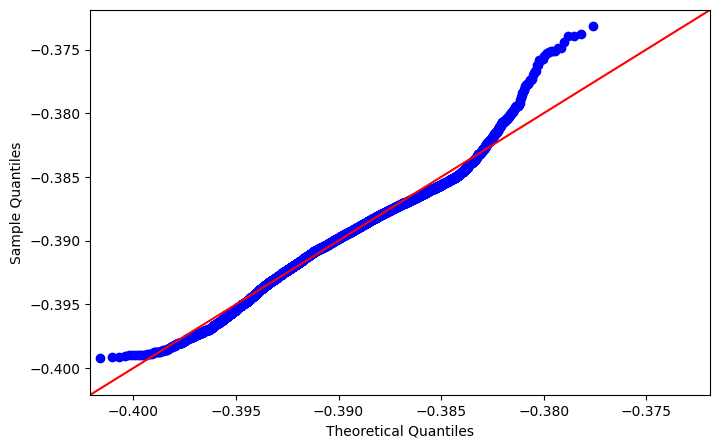

In [150]:
scal = MinMaxScaler()
#s_scal = scal.fit_transform(nitkas[1].drop(columns = ['Дата и время']).to_numpy())
z = nitkas[1]['DK14_SKD_Deg_004.P1']
print(is_norm(z))
p_log = np.log(z)
#mn.ppk_plot(p_log, upper_control_limit=0.1, lower_control_limit=0.4)
mn.ppk_plot(z, upper_control_limit=0.1, lower_control_limit=0.4)
#sm.qqplot(z,loc = z.mean(), scale = z.std(), line = '45') 
#sm.qqplot(p_log, loc=p_log.mean(), scale=p_log.std(), line = '45')


y, fitted_lambda = boxcox(z, lmbda=None)
#c = inv_boxcox(y, fitted_lambda)


mn.ppk_plot(y, upper_control_limit=0.1, lower_control_limit=0.4)
sm.qqplot(y, loc= y.mean(), scale=y.std(), line = '45')


In [9]:
#test
list_5 = ['DK14_SKD_Deg_005.L1_1','DK14_SKD_Deg_005.L1_2',
            'DK14_SKD_Deg_005.L2_1','DK14_SKD_Deg_005.L2_2',
            'DK14_SKD_Deg_005.Q2_2',
            'DK14_SKD_Deg_005.Q3_1_2','DK14_SKD_Deg_005.Q3_2',
            'DK14_SKD_Deg_005.Q3_3','DK14_SKD_Deg_005.Q4',
            'DK14_SKD_Deg_005.F1_M','DK14_SKD_Deg_005.F2_2',
            'DK14_SKD_Deg_005.F3_1.IsOverheat','DK14_SKD_Deg_005.F3_2.IsOverheat',
            'DK14_SKD_Deg_005.F4', 'DK14_SKD_Deg_005.F5',
            'DK14_SKD_Deg_005.F6', 'DK14_SKD_Deg_005.FR3015.IsOverheat',
            'DK14_SKD_Deg_005.I1', 'DK14_SKD_Deg_005.Q2',
            'DK14_SKD_Deg_005.Q5', 'DK14_SKD_Deg_005.Q6',
            'DK14_SKD_Deg_005.State1', 'DK14_SKD_Deg_005.State2',
            'DK14_SKD_Deg_005.TR103_1','DK14_SKD_Deg_005.TR103_2',
            'DK14_SKD_Deg_005.F7_1', 'DK14_SKD_Deg_005.F7_2','DK14_SKD_Deg_005.FRC3015', 'DK14_SKD_Deg_005.T3',# 57.9%, 100.0%, 57.9% missing values
            'DK14_SKD_Deg_005.F3_1.T_sat', 'DK14_SKD_Deg_005.F3_2.T_sat', 'DK14_SKD_Deg_005.FR3015.T_sat',# 6.9% missing values
            #'DK14_SKD_Deg_005.T1', 'DK14_SKD_Deg_005.T2',
            #'DK14_SKD_Deg_005.F3_3.IsOverheat', 'DK14_SKD_Deg_005.F3_3.T_sat'
         ]


list_4 = ['DK14_SKD_Deg_004.L1_1','DK14_SKD_Deg_004.L1_2','DK14_SKD_Deg_004.L2_1','DK14_SKD_Deg_004.L2_2',
          'DK14_SKD_Deg_004.Q2_2','DK14_SKD_Deg_004.Q3_1_2','DK14_SKD_Deg_004.Q3_2','DK14_SKD_Deg_004.Q3_3',
          'DK14_SKD_Deg_004.Q4','DK14_SKD_Deg_004.F7_1','DK14_SKD_Deg_004.F7_2',
          'DK14_SKD_Deg_004.F1_M','DK14_SKD_Deg_004.F2_2','DK14_SKD_Deg_004.F3_1.IsOverheat',
          'DK14_SKD_Deg_004.F3_2.IsOverheat','DK14_SKD_Deg_004.F3_3.IsOverheat','DK14_SKD_Deg_004.F4',
          'DK14_SKD_Deg_004.F5','DK14_SKD_Deg_004.F6','DK14_SKD_Deg_004.FR3012.IsOverheat',
          'DK14_SKD_Deg_004.FRC3012','DK14_SKD_Deg_004.I1','DK14_SKD_Deg_004.Q2',
          'DK14_SKD_Deg_004.Q5','DK14_SKD_Deg_004.Q6','DK14_SKD_Deg_004.State1',
          'DK14_SKD_Deg_004.State2',
          'DK14_SKD_Deg_004.F3_1.T_sat', 'DK14_SKD_Deg_004.F3_2.T_sat', 'DK14_SKD_Deg_004.FR3012.T_sat',#6.9%  missing values
          'DK14_SKD_Deg_004.F3_3.T_sat',
          #'DK14_SKD_Deg_004.T1', 'DK14_SKD_Deg_004.T2'
         ]

list_3 = ['DK14_SKD_Deg_003.L1_1','DK14_SKD_Deg_003.L1_2',
          'DK14_SKD_Deg_003.L2_1','DK14_SKD_Deg_003.L2_2',
          'DK14_SKD_Deg_003.Q2_2', 'DK14_SKD_Deg_003.I1',
          'DK14_SKD_Deg_003.Q3_1_2','DK14_SKD_Deg_003.Q3_2',
          'DK14_SKD_Deg_003.Q3_3','DK14_SKD_Deg_003.Q4',
          'DK14_SKD_Deg_003.F7_1','DK14_SKD_Deg_003.F7_2',
          'DK14_Shop.REZIM_3N','DK14_SKD_Deg_003.F1_M',
          'DK14_SKD_Deg_003.F2_2','DK14_SKD_Deg_003.F3_1.IsOverheat',
          'DK14_SKD_Deg_003.F3_2.IsOverheat','DK14_SKD_Deg_003.F4',
          'DK14_SKD_Deg_003.F5','DK14_SKD_Deg_003.F6',
          'DK14_SKD_Deg_003.FRC3009.IsOverheat','DK14_SKD_Deg_003.Q2',
          'DK14_SKD_Deg_003.Q5','DK14_SKD_Deg_003.Q6',
          'DK14_SKD_Deg_003.State1','DK14_SKD_Deg_003.State2',
          'DK14_SKD_Deg_003.TT100','DK14_SKD_Deg_003.TT101',
          'DK14_SKD_Deg_003.T3', 'DK14_SKD_Deg_003.T4']#72.2%, 55.1%  missing values


list_dop = ['DK14_SKD_Prod.QR1502',#27.9% miss
            'DK14_Shop.AR501_DK2', 'DK14_Shop.AR502_DK2', #100% miss
            #'VR010104EKSKD_TempH20.LHA', 'VR010104EKSTEAM_NORTH.LHA', 'VR010104EKSTEAM_SOUTH.LHA',#57.8% miss
            
           ]


list_tmp_4_5 = list_4.copy()
list_tmp_4_5.extend(list_5)
list_tmp_4_5.extend(nit3)
list_tmp_4_5.extend(list_dop)
list_tmp_4_5.append('index')
print('list_tmp_4_5', len(list_tmp_4_5))
df_4_5 = fin_df[(fin_df['DK14_SKD_Deg_005.F1'] > 0.1)\
              & (fin_df['DK14_SKD_Deg_004.F1'] > 0.1)\
              & (fin_df['Суммарная подача пара на 5 нитку, т/час'] > 5)\
              & (fin_df['120апп.удел.5нитка'] < 5)\
              & (fin_df['34апп.удел.сумма.5нитка'] < 8)\
              & (fin_df['удел.сумм.5нитка'] < 10)\
              & (fin_df['Суммарная подача пара на 4 нитку, т/час'] > 5)\
              & (fin_df['120апп.удел.4нитка'] < 5)\
              & (fin_df['34апп.удел.сумма.4нитка'] < 8)\
              & (fin_df['удел.сумм.4нитка'] < 10)\
              & (fin_df['DK14_SKD_Prod.Mn'] < 80)
              ].reset_index().drop(columns = list_tmp_4_5)
#pandas_profiling.ProfileReport(df = df_4_5, minimal = True).to_file('df_4_5.html')#to_widgets()  

list_tmp_3_5 = list_3.copy()
list_tmp_3_5.extend(list_5)
list_tmp_3_5.extend(nit4)
list_tmp_3_5.extend(list_dop)
list_tmp_3_5.append('index')
print('list_tmp_3_5',len(list_tmp_3_5))
df_3_5 = fin_df[(fin_df['DK14_SKD_Deg_005.F1'] > 0.1)\
              & (fin_df['DK14_SKD_Deg_003.F1'] > 0.1)\
              & (fin_df['Суммарная подача пара на 5 нитку, т/час'] > 5)\
              & (fin_df['120апп.удел.5нитка'] < 5)\
              & (fin_df['34апп.удел.сумма.5нитка'] < 8)\
              & (fin_df['удел.сумм.5нитка'] < 10)\
              & (fin_df['Суммарная подача пара на 3 нитку, т/час'] > 5)\
              & (fin_df['120апп.удел.3нитка'] < 5)\
              & (fin_df['34апп.удел.сумма.3нитка'] < 8)\
              & (fin_df['удел.сумм.3нитка'] < 10)\
              & (fin_df['DK14_Shop.REZIM_3N'] == 0)\
              & (fin_df['DK14_SKD_Prod.Mn'] < 80)
              ].reset_index().drop(columns = list_tmp_3_5)
#pandas_profiling.ProfileReport(df = df_3_5, minimal = True).to_file('df_3_5.html')#to_widgets()  

list_tmp_3_4 = list_4.copy()
list_tmp_3_4.extend(list_3)
list_tmp_3_4.extend(nit5)
list_tmp_3_4.extend(list_dop)
list_tmp_3_4.append('index')
print('list_tmp_3_4',len(list_tmp_3_4))
df_3_4  = fin_df[(fin_df['DK14_SKD_Deg_004.F1'] > 0.1)\
              & (fin_df['DK14_SKD_Deg_003.F1'] > 0.1)\
              & (fin_df['Суммарная подача пара на 4 нитку, т/час'] > 5)\
              & (fin_df['120апп.удел.4нитка'] < 5)\
              & (fin_df['34апп.удел.сумма.4нитка'] < 8)\
              & (fin_df['удел.сумм.4нитка'] < 10)
              & (fin_df['Суммарная подача пара на 3 нитку, т/час'] > 5)\
              & (fin_df['120апп.удел.3нитка'] < 5)\
              & (fin_df['34апп.удел.сумма.3нитка'] < 8)\
              & (fin_df['удел.сумм.3нитка'] < 10)\
              & (fin_df['DK14_Shop.REZIM_3N'] == 0)\
              & (fin_df['DK14_SKD_Deg_004.T1'] > 50)\
              & (fin_df['DK14_SKD_Prod.Mn'] < 80)
              ].reset_index().drop(columns = list_tmp_3_4)
#pandas_profiling.ProfileReport(df = df_3_4, minimal = True).to_file('df_3_4.html')#to_widgets()  

list_tmp_3_4_5 = list_tmp_4_5.copy()
list_tmp_3_4_5.extend(list_3)
print('list_tmp_3_4_5',len(list_tmp_3_4_5))
df_3_4_5  = fin_df[(fin_df['DK14_SKD_Deg_004.F1'] > 0.1)\
              & (fin_df['DK14_SKD_Deg_003.F1'] > 0.1)\
              & (fin_df['DK14_SKD_Deg_005.F1'] > 0.1)\
              & (fin_df['Суммарная подача пара на 4 нитку, т/час'] > 5)\
              & (fin_df['120апп.удел.4нитка'] < 5)\
              & (fin_df['34апп.удел.сумма.4нитка'] < 8)\
              & (fin_df['удел.сумм.4нитка'] < 10)
              & (fin_df['Суммарная подача пара на 3 нитку, т/час'] > 5)\
              & (fin_df['120апп.удел.3нитка'] < 5)\
              & (fin_df['34апп.удел.сумма.3нитка'] < 8)\
              & (fin_df['удел.сумм.3нитка'] < 10)\
              & (fin_df['DK14_Shop.REZIM_3N'] == 0)\
              & (fin_df['Суммарная подача пара на 5 нитку, т/час'] > 5)\
              & (fin_df['120апп.удел.5нитка'] < 5)\
              & (fin_df['34апп.удел.сумма.5нитка'] < 8)\
              & (fin_df['удел.сумм.5нитка'] < 10)\
              & (fin_df['DK14_SKD_Prod.Mn'] < 80)
              ].reset_index().drop(columns = list_tmp_3_4_5)
#pandas_profiling.ProfileReport(df = df_3_4_5, minimal = True).to_file('df_3_4_5.html')#to_widgets()  
print('df_3_4:',df_3_4.shape)
print('df_3_5:',df_3_5.shape)
print('df_4_5:',df_4_5.shape)
print('df_3_4_5:',df_3_4_5.shape)

list_tmp_4_5 119
list_tmp_3_5 118
list_tmp_3_4 120
list_tmp_3_4_5 149
df_3_4: (3707, 52)
df_3_5: (4108, 54)
df_4_5: (25636, 53)
df_3_4_5: (0, 53)


In [41]:
df_4  = fin_df[['DK14_SKD_Deg_004.P1','Дата и время','Массовая доля углеводородов, %']][(fin_df['DK14_SKD_Deg_004.P1'] > 0.2)\
               & (fin_df['DK14_SKD_Deg_004.P1'] < 0.3)\
               & (fin_df['Дата и время'] > datetime(2019,6,3,0,0))\
               & (fin_df['Дата и время'] < datetime(2019,6,5,0,0))\
#               & (fin_df['120апп.удел.4нитка'] < 5)\
#               & (fin_df['34апп.удел.сумма.4нитка'] < 8)\
#               & (fin_df['удел.сумм.4нитка'] < 10)
              ]#.reset_index()
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df_4)
#df_4['DK14_SKD_Deg_004.P1'].plot.kde()
#mn.ppk_plot(df_4, lower_control_limit=0.2, upper_control_limit=0.5)

     DK14_SKD_Deg_004.P1        Дата и время  Массовая доля углеводородов, %
100             0.297984 2019-06-03 00:30:00                             NaN
101             0.296699 2019-06-03 01:00:00                             NaN
103             0.299998 2019-06-03 02:00:00                             NaN
104             0.297126 2019-06-03 02:30:00                             NaN
105             0.295999 2019-06-03 03:00:00                             NaN
106             0.296580 2019-06-03 03:30:00                             NaN
107             0.294940 2019-06-03 04:00:00                             NaN
108             0.294028 2019-06-03 04:30:00                             NaN
109             0.290876 2019-06-03 05:00:00                             NaN
110             0.298510 2019-06-03 05:30:00                             NaN
120             0.295479 2019-06-03 10:30:00                             NaN
121             0.296352 2019-06-03 11:00:00                             NaN

In [22]:
print(df_4_5.columns.to_list())
df45 = df_4_5[['удел.сумм.4нитка','удел.сумм.5нитка','Массовая доля углеводородов, %',
         'Дата и время', 'DK14_SKD_Deg_004.T1', 'DK14_SKD_Deg_004.T2',
         'DK14_SKD_Deg_005.T1', 'DK14_SKD_Deg_005.T2',
          'VR010104EKSTEAM_NORTH.LHA','VR010104EKSTEAM_SOUTH.LHA',
               'DK14_SKD_Deg_005.P1', 'DK14_SKD_Deg_005.P2',
               'DK14_SKD_Deg_004.P1', 'DK14_SKD_Deg_004.P2',
               'Суммарная подача пара на 4 нитку, т/час', 'Суммарная подача пара на 5 нитку, т/час',
               'DK14_SKD_Deg_004.F1','DK14_SKD_Deg_005.F1'
               
        ]][(df_4_5['Дата и время']> datetime(2020,1,1))].reset_index().drop(columns = 'index').sort_values(by = 'Дата и время')
#df45.to_excel('tmp.xlsx')
print(df45.describe(), df45.median())
print('---------------------------------------------------------------------------------------')
tmp45 = df45[
             
              #df45['удел.сумм.4нитка'] < 4.5)\
             #&(df45['удел.сумм.5нитка'] < 4.5)\
             (df45['DK14_SKD_Deg_004.P2'] > 0.7)]
print(tmp45.describe(),tmp45.median())
sns.lineplot(data=df45, x="Дата и время", y="DK14_SKD_Deg_004.T1")
sns.lineplot(data=df45, x="Дата и время", y="DK14_SKD_Deg_004.T2")
sns.lineplot(data=df45, x="Дата и время", y="удел.сумм.4нитка")
sns.lineplot(data=df45, x="Дата и время", y="Массовая доля углеводородов, %")
#print(df45.drop(columns = 'Дата и время').astype(float).corr())
#pandas_profiling.ProfileReport(df = df45).to_file('df_4_5.html')

['120апп.удел.4нитка', '120апп.удел.5нитка', '34апп.сумма.4нитка', '34апп.сумма.5нитка', '34апп.удел.сумма.4нитка', '34апп.удел.сумма.5нитка', 'DK14_SKD_Deg_004.F1', 'DK14_SKD_Deg_004.F2_1', 'DK14_SKD_Deg_004.F3_1', 'DK14_SKD_Deg_004.F3_2', 'DK14_SKD_Deg_004.F3_3', 'DK14_SKD_Deg_004.FR3012', 'DK14_SKD_Deg_004.I2', 'DK14_SKD_Deg_004.L1', 'DK14_SKD_Deg_004.L2', 'DK14_SKD_Deg_004.P1', 'DK14_SKD_Deg_004.P2', 'DK14_SKD_Deg_004.P2_1', 'DK14_SKD_Deg_004.T1', 'DK14_SKD_Deg_004.T2', 'DK14_SKD_Deg_004.T3', 'DK14_SKD_Deg_004.T4', 'DK14_SKD_Deg_005.F1', 'DK14_SKD_Deg_005.F1.8H', 'DK14_SKD_Deg_005.F2_1', 'DK14_SKD_Deg_005.F3_1', 'DK14_SKD_Deg_005.F3_2', 'DK14_SKD_Deg_005.F3_3', 'DK14_SKD_Deg_005.F3_3.IsOverheat', 'DK14_SKD_Deg_005.F3_3.T_sat', 'DK14_SKD_Deg_005.FR3015', 'DK14_SKD_Deg_005.I2', 'DK14_SKD_Deg_005.L1', 'DK14_SKD_Deg_005.L2', 'DK14_SKD_Deg_005.P1', 'DK14_SKD_Deg_005.P2', 'DK14_SKD_Deg_005.P2_1', 'DK14_SKD_Deg_005.T1', 'DK14_SKD_Deg_005.T2', 'DK14_SKD_Deg_005.T4', 'DK14_SKD_Prod.Mn', 'DK

<AxesSubplot:xlabel='Дата и время', ylabel='DK14_SKD_Deg_004.T1'>

In [14]:
rename_4_5_dict = {'120апп.удел.4нитка':'120апп.удел_x',\
 '120апп.удел.5нитка':'120апп.удел_y',
 '34апп.сумма.4нитка':'34апп.сумма_x',
 '34апп.сумма.5нитка':'34апп.сумма_y',
 '34апп.удел.сумма.4нитка':'34апп.удел.сумма_x',
 '34апп.удел.сумма.5нитка':'34апп.удел.сумма_y',
 'DK14_SKD_Deg_004.F1': 'F1_x',
 'DK14_SKD_Deg_004.F2_1':'F2_1_x',
 'DK14_SKD_Deg_004.F3_1':'F3_1_x',
 'DK14_SKD_Deg_004.F3_1.T_sat': 'F3_1.T_sat_x',
 'DK14_SKD_Deg_004.F3_2': 'F3_2_x',
 'DK14_SKD_Deg_004.F3_2.T_sat': 'F3_2.T_sat_x',
 'DK14_SKD_Deg_004.F3_3': 'F3_3_x',
 'DK14_SKD_Deg_004.F3_3.T_sat': 'F3_3.T_sat_x',
 'DK14_SKD_Deg_004.FR3012': 'FR30_x',
 'DK14_SKD_Deg_004.FR3012.T_sat':'FR30.T_sat_x',
 'DK14_SKD_Deg_004.I2':'I2_x',
 'DK14_SKD_Deg_004.L1': 'L1_x',
 'DK14_SKD_Deg_004.L2':'L2_x',
 'DK14_SKD_Deg_004.P1':'P1_x',
 'DK14_SKD_Deg_004.P2':'P2_x',
 'DK14_SKD_Deg_004.P2_1':'P2_1_x',
 'DK14_SKD_Deg_004.T3':'T3_x',
 'DK14_SKD_Deg_004.T4':'T4_x',
 'DK14_SKD_Deg_005.F1':'F1_y',
 'DK14_SKD_Deg_005.F1.8H':'F1.8H_y',
 'DK14_SKD_Deg_005.F2_1':'F2_1_y',
 'DK14_SKD_Deg_005.F3_1':'F3_1_y',
 'DK14_SKD_Deg_005.F3_2':'F3_2_y',
 'DK14_SKD_Deg_005.F3_3':'F3_3_y',
 'DK14_SKD_Deg_005.F3_3.IsOverheat':'F3_3.IsOverheat_y',
 'DK14_SKD_Deg_005.F3_3.T_sat':'F3_3.T_sat_y',
 'DK14_SKD_Deg_005.FR3015':'FR30_y',
 'DK14_SKD_Deg_005.I2':'I2_y',
 'DK14_SKD_Deg_005.L1':'L1_y',
 'DK14_SKD_Deg_005.L2':'L2_y',
 'DK14_SKD_Deg_005.P1':'P1_y',
 'DK14_SKD_Deg_005.P2':'P2_y',
 'DK14_SKD_Deg_005.P2_1':'P2_1_y',
 'DK14_SKD_Deg_005.T4':'T4_y',
 'Суммарная подача пара на 4 нитку, т/час':'Суммарная подача пара_x',
 'Суммарная подача пара на 5 нитку, т/час':'Суммарная подача пара_y',
 'удел.сумм.4нитка':'удел.сумм_x',
 'удел.сумм.5нитка':'удел.сумм_y'}

rename_3_5_dict = {'120апп.удел.3нитка':'120апп.удел_x',\
 '120апп.удел.5нитка':'120апп.удел_y',
 '34апп.сумма.3нитка':'34апп.сумма_x',
 '34апп.сумма.5нитка':'34апп.сумма_y',
 '34апп.удел.сумма.3нитка':'34апп.удел.сумма_x',
 '34апп.удел.сумма.5нитка':'34апп.удел.сумма_y',
 'DK14_SKD_Deg_003.F1': 'F1_x',
 'DK14_SKD_Deg_003.F2_1':'F2_1_x',
 'DK14_SKD_Deg_003.F3_1':'F3_1_x',
 'DK14_SKD_Deg_003.F3_1.T_sat': 'F3_1.T_sat_x',
 'DK14_SKD_Deg_003.F3_2': 'F3_2_x',
 'DK14_SKD_Deg_003.F3_2.T_sat': 'F3_2.T_sat_x',
 'DK14_SKD_Deg_003.F3_3': 'F3_3_x',
 'DK14_SKD_Deg_003.F3_3.T_sat': 'F3_3.T_sat_x',
 'DK14_SKD_Deg_003.FRC3009': 'FR30_x',
 'DK14_SKD_Deg_003.FRC3009.T_sat':'FR30.T_sat_x',
 'DK14_SKD_Deg_003.I2':'I2_x',
 'DK14_SKD_Deg_003.L1': 'L1_x',
 'DK14_SKD_Deg_003.L2':'L2_x',
 'DK14_SKD_Deg_003.P1':'P1_x',
 'DK14_SKD_Deg_003.P2':'P2_x',
 'DK14_SKD_Deg_003.P2_1':'P2_1_x',
 'DK14_SKD_Deg_003.T3':'T3_x',
 'DK14_SKD_Deg_003.T4':'T4_x',
 'DK14_SKD_Deg_005.F1':'F1_y',
 'DK14_SKD_Deg_005.F1.8H':'F1.8H_y',
 'DK14_SKD_Deg_005.F2_1':'F2_1_y',
 'DK14_SKD_Deg_005.F3_1':'F3_1_y',
 'DK14_SKD_Deg_005.F3_2':'F3_2_y',
 'DK14_SKD_Deg_005.F3_3':'F3_3_y',
 'DK14_SKD_Deg_005.F3_3.IsOverheat':'F3_3.IsOverheat_y',
 'DK14_SKD_Deg_005.F3_3.T_sat':'F3_3.T_sat_y',
 'DK14_SKD_Deg_005.FR3015':'FR30_y',
 'DK14_SKD_Deg_005.I2':'I2_y',
 'DK14_SKD_Deg_005.L1':'L1_y',
 'DK14_SKD_Deg_005.L2':'L2_y',
 'DK14_SKD_Deg_005.P1':'P1_y',
 'DK14_SKD_Deg_005.P2':'P2_y',
 'DK14_SKD_Deg_005.P2_1':'P2_1_y',
 'DK14_SKD_Deg_005.T4':'T4_y',
 'Суммарная подача пара на 3 нитку, т/час':'Суммарная подача пара_x',
 'Суммарная подача пара на 5 нитку, т/час':'Суммарная подача пара_y',
 'удел.сумм.3нитка':'удел.сумм_x',
 'удел.сумм.5нитка':'удел.сумм_y'}

rename_3_4_dict = {'120апп.удел.3нитка':'120апп.удел_x',\
 '120апп.удел.4нитка':'120апп.удел_y',
 '34апп.сумма.3нитка':'34апп.сумма_x',
 '34апп.сумма.4нитка':'34апп.сумма_y',
 '34апп.удел.сумма.3нитка':'34апп.удел.сумма_x',
 '34апп.удел.сумма.4нитка':'34апп.удел.сумма_y',
 'DK14_SKD_Deg_003.F1': 'F1_x',
 'DK14_SKD_Deg_003.F2_1':'F2_1_x',
 'DK14_SKD_Deg_003.F3_1':'F3_1_x',
 'DK14_SKD_Deg_003.F3_1.T_sat': 'F3_1.T_sat_x',
 'DK14_SKD_Deg_003.F3_2': 'F3_2_x',
 'DK14_SKD_Deg_003.F3_2.T_sat': 'F3_2.T_sat_x',
 'DK14_SKD_Deg_003.F3_3': 'F3_3_x',
 'DK14_SKD_Deg_003.F3_3.T_sat': 'F3_3.T_sat_x',
 'DK14_SKD_Deg_003.FRC3009': 'FR30_x',
 'DK14_SKD_Deg_003.FRC3009.T_sat':'FR30.T_sat_x',
 'DK14_SKD_Deg_003.I2':'I2_x',
 'DK14_SKD_Deg_003.L1': 'L1_x',
 'DK14_SKD_Deg_003.L2':'L2_x',
 'DK14_SKD_Deg_003.P1':'P1_x',
 'DK14_SKD_Deg_003.P2':'P2_x',
 'DK14_SKD_Deg_003.P2_1':'P2_1_x',
 'DK14_SKD_Deg_003.T3':'T3_x',
 'DK14_SKD_Deg_003.T4':'T4_x',
 'DK14_SKD_Deg_004.F1':'F1_y',
 'DK14_SKD_Deg_004.F1.8H':'F1.8H_y',
 'DK14_SKD_Deg_004.F2_1':'F2_1_y',
 'DK14_SKD_Deg_004.F3_1':'F3_1_y',
 'DK14_SKD_Deg_004.F3_2':'F3_2_y',
 'DK14_SKD_Deg_004.F3_3':'F3_3_y',
 'DK14_SKD_Deg_004.F3_3.IsOverheat':'F3_3.IsOverheat_y',
 'DK14_SKD_Deg_004.F3_3.T_sat':'F3_3.T_sat_y',
 'DK14_SKD_Deg_004.FR3012':'FR30_y',
 'DK14_SKD_Deg_004.I2':'I2_y',
 'DK14_SKD_Deg_004.L1':'L1_y',
 'DK14_SKD_Deg_004.L2':'L2_y',
 'DK14_SKD_Deg_004.P1':'P1_y',
 'DK14_SKD_Deg_004.P2':'P2_y',
 'DK14_SKD_Deg_004.P2_1':'P2_1_y',
 'DK14_SKD_Deg_004.T3':'T3_y',
 'DK14_SKD_Deg_004.T4':'T4_y',
 'Суммарная подача пара на 3 нитку, т/час':'Суммарная подача пара_x',
 'Суммарная подача пара на 4 нитку, т/час':'Суммарная подача пара_y',
 'удел.сумм.3нитка':'удел.сумм_x',
 'удел.сумм.4нитка':'удел.сумм_y'}

In [16]:
#TODO - CHECK T1 T2
df_4_5[np.isnan(df_4_5['Массовая доля углеводородов, %']) == False]

,120апп.удел.4нитка,120апп.удел.5нитка,34апп.сумма.4нитка,34апп.сумма.5нитка,34апп.удел.сумма.4нитка,34апп.удел.сумма.5нитка,DK14_SKD_Deg_004.F1,DK14_SKD_Deg_004.F2_1,DK14_SKD_Deg_004.F3_1,DK14_SKD_Deg_004.F3_1.T_sat,...,VR010104EKSKD_TempH20.LHA,VR010104EKSTEAM_NORTH.LHA,VR010104EKSTEAM_SOUTH.LHA,Дата и время,"Массовая доля тримеров, %","Массовая доля углеводородов, %","Суммарная подача пара на 4 нитку, т/час","Суммарная подача пара на 5 нитку, т/час",удел.сумм.4нитка,удел.сумм.5нитка
200,1.763722,1.575105,23.931800,26.427704,2.914162,2.870462,5.502200,85.895645,15.921303,168.730209,...,NaN,NaN,NaN,2019-06-05 09:00:00,0.119,0.10,38.415905,40.929347,4.677884,4.445568
223,1.870773,1.876146,23.940373,25.210245,3.092245,3.266750,5.187186,78.841293,15.914431,168.723526,...,NaN,NaN,NaN,2019-06-05 21:00:00,0.140,0.06,38.424025,39.688885,4.963017,5.142896
247,1.739779,1.739933,23.672192,25.101031,2.836260,3.008550,5.592000,78.997139,15.870751,168.723312,...,NaN,NaN,NaN,2019-06-06 09:00:00,0.097,0.08,38.192855,39.617702,4.576039,4.748483
269,1.752289,1.735939,23.655230,25.173828,2.856215,3.016723,5.548954,86.435814,15.836429,168.715439,...,NaN,NaN,NaN,2019-06-06 21:00:00,0.180,0.06,38.167723,39.659817,4.608504,4.752661
293,1.744634,1.731850,23.852006,27.085421,2.867751,3.231595,5.572605,85.200745,16.001528,168.719910,...,NaN,NaN,NaN,2019-06-07 09:00:00,0.036,0.13,38.362688,41.600824,4.612385,4.963445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25555,1.610737,1.550422,26.069918,27.253720,2.895696,3.024488,6.032003,89.559937,17.589441,168.714233,...,NaN,NaN,NaN,2019-05-30 04:00:00,NaN,0.19,40.571366,41.224603,4.506433,4.574910
25564,1.873044,1.803984,25.844509,24.920626,3.334319,3.212669,5.193211,79.394989,18.759924,168.709427,...,NaN,NaN,NaN,2019-05-30 08:30:00,0.095,0.07,40.362584,38.914106,5.207363,5.016653
25610,1.613157,1.558345,25.531441,26.850541,2.838863,2.983813,6.025676,90.993332,17.233484,168.702637,...,NaN,NaN,NaN,2019-05-31 09:00:00,0.094,0.38,40.039442,40.873673,4.452020,4.542158
25618,1.615449,1.554553,25.468163,26.937113,2.837896,2.987773,6.012789,90.540077,17.224983,168.702637,...,NaN,NaN,NaN,2019-05-31 13:00:00,NaN,0.06,39.965710,40.952625,4.453345,4.542326


In [15]:
#1136  - всего анализов на органику
#528 от df_4_5
#149 от df_3_4
#184 от 3_5
#Подготовка df (MAIN CELL)
number_of_organic_tests = fin_df[np.isnan(fin_df['Массовая доля углеводородов, %']) == False].shape[0]
print('всего анализов на органику:', number_of_organic_tests)

#df_4_5 = df_4_5.drop(columns = tmp_list)

dfs = []
dfs.append(df_4_5[np.isnan(df_4_5['Массовая доля углеводородов, %']) == False]\
                                                .reset_index()\
                                                .drop(columns = ['Массовая доля тримеров, %', 'Дата и время', 'index'])\
                                                .dropna()\
                                                .astype(float))
dfs.append(df_3_4[np.isnan(df_3_4['Массовая доля углеводородов, %']) == False]\
                                                .reset_index()\
                                                .drop(columns = ['Массовая доля тримеров, %', 'Дата и время', 'index'])\
                                                .dropna()\
                                                .astype(float))
dfs.append(df_3_5[np.isnan(df_3_5['Массовая доля углеводородов, %']) == False]\
                                                .reset_index()\
                                                .drop(columns = ['Массовая доля тримеров, %', 'Дата и время', 'index'])\
                                                .dropna()\
                                                .astype(float))

losing_of_tests = number_of_organic_tests
for i in dfs:
    print(i.shape)
    losing_of_tests -= i.shape[0]
print('Потеряно анализов на органику:', losing_of_tests)

всего анализов на органику: 2394
(492, 58)
(142, 54)
(185, 55)
Потеряно анализов на органику: 1575


In [19]:
#TEST CELL append'a линий
number_of_organic_tests = fin_df[np.isnan(fin_df['Массовая доля углеводородов, %']) == False].shape[0]
print('всего анализов на органику:', number_of_organic_tests)

df_4_5_tmp = df_4_5.rename(columns = rename_4_5_dict)
df_3_4_tmp = df_3_4.rename(columns = rename_3_4_dict).drop(columns=['DK14_SKD_Deg_003.T1','DK14_SKD_Deg_003.T2'])
df_3_5_tmp = df_3_5.rename(columns = rename_3_5_dict).drop(columns=['DK14_SKD_Deg_003.T1','DK14_SKD_Deg_003.T2'])

dfs = []
dfs.append(df_4_5_tmp[np.isnan(df_4_5_tmp['Массовая доля углеводородов, %']) == False]\
                                                .reset_index()\
                                                .drop(columns = ['Массовая доля тримеров, %', 'Дата и время', 'index'])\
                                                .dropna()\
                                                .astype(float))
dfs.append(df_3_4_tmp[np.isnan(df_3_4_tmp['Массовая доля углеводородов, %']) == False]\
                                                .reset_index()\
                                                .drop(columns = ['Массовая доля тримеров, %', 'Дата и время', 'index'])\
                                                .dropna()\
                                                .astype(float))
dfs.append(df_3_5_tmp[np.isnan(df_3_5_tmp['Массовая доля углеводородов, %']) == False]\
                                                .reset_index()\
                                                .drop(columns = ['Массовая доля тримеров, %', 'Дата и время', 'index'])\
                                                .dropna()\
                                                .astype(float))
sum_df_tmp = dfs[0].append(dfs[1])
sum_df_tmp = sum_df_tmp.append(dfs[2])
dfs.append(sum_df_tmp.dropna(axis = 1))


losing_of_tests = number_of_organic_tests
for i in dfs:
    print(i.shape)
    losing_of_tests -= i.shape[0]
print('Потеряно анализов на органику:', losing_of_tests)
'TEST_tmp'

всего анализов на органику: 2394
(1284, 42)
(142, 43)
(185, 43)
(1611, 39)
Потеряно анализов на органику: -828


'TEST_tmp'

In [84]:
#Данные для обучения и теста модели
#При объеме данных менее 400 наблюдений
#линейная регрессия не способна обучиться чему-либо
scaler = MinMaxScaler()#StandardScaler()
tmp_df = dfs[-1]

scaler_for_neural = StandardScaler()
arr_for_neural = scaler_for_neural.fit_transform(tmp_df)
X_for_neural = np.delete(arr_for_neural, tmp_df.columns.to_list().index('Массовая доля углеводородов, %'), 1)
y_for_neural = arr_for_neural[:,tmp_df.columns.to_list().index('Массовая доля углеводородов, %')]
X_train_neural, X_test_neural, y_train_neural, y_test_neural = train_test_split(X_for_neural, y_for_neural, random_state=20)

n_arr_norm = scaler.fit_transform(tmp_df)
print('Размер данных=', tmp_df.shape)
#X = tmp_df.drop(columns = ['Массовая доля углеводородов, %'])
#y = tmp_df['Массовая доля углеводородов, %']
X = np.delete(n_arr_norm, tmp_df.columns.to_list().index('Массовая доля углеводородов, %'), 1)
y = n_arr_norm[:,tmp_df.columns.to_list().index('Массовая доля углеводородов, %')]
#X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), random_state=20)#, test_size = 0.2, train_size = 0.8)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20)#, test_size = 0.2, train_size = 0.8)
print('Обучающие датасеты', X_train, y_train)
print('Размер Х_train', len(X_train))
print('Размер Х_test', len(X_test))

Размер данных= (1611, 39)
Обучающие датасеты [[0.40459266 0.06740558 0.8682705  ... 0.86087089 0.55044227 0.07385121]
 [0.39773344 0.07029525 0.86457649 ... 0.81685543 0.5443978  0.06354913]
 [0.50953432 0.18899852 0.76669936 ... 0.49935789 0.60294405 0.15832224]
 ...
 [0.38044533 0.13710379 0.8717528  ... 0.81058234 0.53250166 0.14321596]
 [0.51711811 0.1653725  0.74496373 ... 0.46404034 0.60062353 0.13465678]
 [0.48060604 0.15045228 0.76449266 ... 0.60589636 0.56244439 0.10937815]] [0.01234568 0.00548697 0.01097394 ... 0.02194787 0.00823045 0.00823045]
Размер Х_train 1208
Размер Х_test 403


In [71]:
# Коэффициент детерминации R-квадрат для модели с константой принимает значения от 0 до 1.
# Чем ближе значение коэффициента к 1, тем сильнее зависимость.
# При оценке регрессионных моделей это интерпретируется как соответствие модели данным.
# Для приемлемых моделей предполагается, что коэффициент детерминации должен быть хотя бы не меньше 50 %
# (в этом случае коэффициент множественной корреляции превышает по модулю 70 %). 
# Модели с коэффициентом детерминации выше 80 % можно признать достаточно хорошими (коэффициент корреляции превышает 90 %).
# Значение коэффициента детерминации 1 означает функциональную зависимость между переменными.
print('Линейная регрессия, метод наименьших квадратов:')
lr = LinearRegression().fit(X_train, y_train)
print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))
print("R-квадрат на обучающем наборе: {:.2f}".format(lr.score(X_train, y_train)))
print("R-квадрат на тестовом наборе: {:.2f}".format(lr.score(X_test, y_test)))
print('mse:', mean_squared_error(y_test, lr.predict(X_test)))
#lr.predict(X_test)

Линейная регрессия, метод наименьших квадратов:
lr.coef_: [ 1.95962452e+11  6.04638817e+10  1.29463030e+11  3.79694379e+11
  4.47004031e+11  8.82434338e+10 -7.82180172e-02 -5.35904146e-02
  5.23593975e-02  1.80005723e-01 -2.61976241e-03 -5.71260783e-02
  8.06551522e-03  6.23865732e+10  9.12908311e+11  1.41223655e+10
  5.59507827e+11  7.23692718e+10  6.64766831e+11  1.51954339e+10
  4.37718789e+11  3.05758829e-01 -2.65392232e-02  1.39393788e-01
 -5.28382239e-02 -2.17994286e-01 -1.43897411e-01  6.40288881e-02
  6.99893710e-02  2.17375839e-02 -1.13639228e-02  4.54909803e-01
 -2.76853889e-01  6.54290387e-02 -2.82505495e+11 -1.80065020e+12
 -6.38810649e+11 -1.45034692e+11]
lr.intercept_: -304572570938.7281
R-квадрат на обучающем наборе: 0.51
R-квадрат на тестовом наборе: 0.49
mse: 0.010798476093224804


In [70]:
#Гребневая регрессия(L2 регуляризация[alpha])
#Оптимальное значение alpha зависит от конкретного используемого набора данных. 
#Увеличение alpha заставляет коэффициенты сжиматься до близких к нулю значений,
#что снижает качество работы модели на обучающем наборе, но может улучшить ее обобщающую способность.
#best params {'alpha': 1}
#best score 0.4651694547672382
parameters = {'alpha':range(200)}
ridge = Ridge()
ridge_grid = GridSearchCV(ridge, parameters,
cv=5, n_jobs=-1,
verbose=True)
ridge_grid.fit(X_train, y_train)
print('best params',ridge_grid.best_params_)
print('best score',ridge_grid.best_score_)
print('Гребневая регрессия(L2 регуляризация[alpha])')
for alpha in [0, 0.0001, 0.0005,0.001, 0.01, 0.02, 0.005, 0.0075, 0.1, 0.3, 0.5, 1, 3, 10, 15, 50, 74, 100]:
    ridge = Ridge(alpha = alpha).fit(X_train, y_train)
    print('alpha =', alpha )
    print("R-квадрат на обучающем наборе: {:.2f}".format(ridge.score(X_train, y_train)))
    print("R-квадрат на тестовом наборе: {:.2f}".format(ridge.score(X_test, y_test)))
    print('mse:', mean_squared_error(y_test, ridge.predict(X_test)))


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.3s


best params {'alpha': 1}
best score 0.4651694547672382
Гребневая регрессия(L2 регуляризация[alpha])
alpha = 0
R-квадрат на обучающем наборе: 0.51
R-квадрат на тестовом наборе: 0.48
mse: 0.010984279145805484
alpha = 0.0001
R-квадрат на обучающем наборе: 0.51
R-квадрат на тестовом наборе: 0.49
mse: 0.010800278509960097
alpha = 0.0005
R-квадрат на обучающем наборе: 0.51
R-квадрат на тестовом наборе: 0.49
mse: 0.010797986812788225
alpha = 0.001
R-квадрат на обучающем наборе: 0.51
R-квадрат на тестовом наборе: 0.49
mse: 0.01079568266489487
alpha = 0.01
R-квадрат на обучающем наборе: 0.51
R-квадрат на тестовом наборе: 0.49
mse: 0.010782249564010537
alpha = 0.02
R-квадрат на обучающем наборе: 0.51
R-квадрат на тестовом наборе: 0.49
mse: 0.010776713509734966
alpha = 0.005
R-квадрат на обучающем наборе: 0.51
R-квадрат на тестовом наборе: 0.49
mse: 0.010786759548810096
alpha = 0.0075
R-квадрат на обучающем наборе: 0.51
R-квадрат на тестовом наборе: 0.49
mse: 0.010784167148575477
alpha = 0.1
R-кв

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.7s finished


In [69]:
#Лассо (L1 регуляризация[alpha])
#Результат L1 регуляризации заключается в том,
#что при использовании лассо некоторые коэффициенты становятся равны точно нулю.
#best params {'alpha': 0}
#best score 0.4561862495198607
parameters = {'alpha':range(200)}
lasso = Lasso()
lasso_grid = GridSearchCV(lasso, parameters,
cv=5, n_jobs=-1,
verbose=True)
lasso_grid.fit(X_train, y_train)
print('best params',lasso_grid.best_params_)
print('best score',lasso_grid.best_score_)
for alpha in [0, 0.0001, 0.0005,0.001, 0.01, 0.02, 0.005, 0.0075, 0.1, 0.3, 0.5, 1, 3, 10, 15, 50, 100]:
    lasso = Lasso(alpha = alpha).fit(X_train, y_train)
    print("R-квадрат на обучающем наборе: {:.2f}".format(lasso.score(X_train, y_train)))
    print("R-квадрат на контрольном наборе: {:.2f}".format(lasso.score(X_test, y_test)))
    print('mse:', mean_squared_error(y_test, lasso.predict(X_test)))
    print("Количество использованных признаков: {}".format(np.sum(lasso.coef_ != 0)))
    print('################################################')
#print(lasso.coef_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.3s


best params {'alpha': 0}
best score 0.4561862495198607
R-квадрат на обучающем наборе: 0.51
R-квадрат на контрольном наборе: 0.49
mse: 0.010798382040926348
Количество использованных признаков: 38
################################################
R-квадрат на обучающем наборе: 0.50
R-квадрат на контрольном наборе: 0.49
mse: 0.01081392760508663
Количество использованных признаков: 24
################################################
R-квадрат на обучающем наборе: 0.46
R-квадрат на контрольном наборе: 0.46
mse: 0.011359108614982405
Количество использованных признаков: 14
################################################
R-квадрат на обучающем наборе: 0.44
R-квадрат на контрольном наборе: 0.44
mse: 0.011818758670175367
Количество использованных признаков: 8
################################################
R-квадрат на обучающем наборе: 0.15
R-квадрат на контрольном наборе: 0.15
mse: 0.01791818846310322
Количество использованных признаков: 2
################################################
R-кв

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.8s finished


In [68]:
parameters = {'max_depth' : range(10)}
tree = DecisionTreeRegressor(random_state = 0)
tree_grid = GridSearchCV(tree, parameters,
cv=5, n_jobs=-1,
verbose=True)
tree_grid.fit(X_train, y_train)
print('best params',tree_grid.best_params_)
print('best score',tree_grid.best_score_)
tree = DecisionTreeRegressor(random_state=0, max_depth = 4)
tree.fit(X_train, y_train)
print("Правильность на обучающем наборе: {:.3f}".format(tree.score(X_train, y_train)))
print("Правильность на тестовом наборе: {:.3f}".format(tree.score(X_test, y_test)))
print('mse:', mean_squared_error(y_test, tree.predict(X_test)))
print("Важности признаков:\n{}".format(tree.feature_importances_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best params {'max_depth': 4}
best score 0.43970478573394356
Правильность на обучающем наборе: 0.589
Правильность на тестовом наборе: 0.459
mse: 0.01139233159666294
Важности признаков:
[1.08967767e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.26074801e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.05787550e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.21910995e-02 3.60200560e-02
 1.73619914e-02 4.41511525e-01 3.04834644e-02 5.58170502e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.74527874e-01
 0.00000000e+00 1.14988689e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished


In [67]:
#Случайный лес
#best params {'max_depth': 4, 'max_features': 22, 'n_estimators': 100}
#best score 0.5279822164083109
#4.2min
#-----------------------
#RandomForestRegressor(n_estimators=200, random_state=33,max_features = 38)
#Правильность на обучающем наборе: 0.937
#Правильность на тестовом наборе: 0.564

parameters = {'max_depth' : range(5), 'n_estimators': [50,100,150,200],'max_features':range(38)}

# forest = RandomForestRegressor(random_state = 0)
# forest_grid = GridSearchCV(forest, parameters,
# cv=5, n_jobs=-1,
# verbose=True)
# forest_grid.fit(X_train, y_train)
# print('best params',forest_grid.best_params_)
# print('best score',forest_grid.best_score_)
forest = RandomForestRegressor(n_estimators=100, random_state=33,max_features = 22, max_depth = 4)
forest.fit(X_train, y_train)
print("Правильность на обучающем наборе: {:.3f}".format(forest.score(X_train, y_train)))
print("Правильность на тестовом наборе: {:.3f}".format(forest.score(X_test, y_test)))
print('mse:', mean_squared_error(y_test, forest.predict(X_test)))

Правильность на обучающем наборе: 0.626
Правильность на тестовом наборе: 0.534
mse: 0.009807346952277123


In [66]:
#Градиентный бустинг
#best params {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 14, 'n_estimators': 200}
#best score 0.5539923066393246
#33.8min
parameters = {'max_depth' : range(5), 'n_estimators': [50,100,150,200],'max_features':range(38),\
              'learning_rate':[0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1]}

#gbr = GradientBoostingRegressor(random_state = 11)
#gbr_grid = GridSearchCV(gbr, parameters,
#cv=5, n_jobs=-1,
#verbose=True)
#gbr_grid.fit(X_train, y_train)
#print('best params',gbr_grid.best_params_)
#print('best score',gbr_grid.best_score_)


#for i in [0.0001, 0.0005,0.001, 0.01, 0.02, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 1]:
#gbr_grid.best_params_['learning_rate']
gbrt = GradientBoostingRegressor(random_state=11, learning_rate=0.1, max_depth=4, max_features=14, n_estimators=200)

gbrt.fit(X_train, y_train)
print("Правильность на обучающем наборе: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Правильность на тестовом наборе: {:.3f}".format(gbrt.score(X_test, y_test)))
print('mse:', mean_squared_error(y_test, gbrt.predict(X_test)))

Правильность на обучающем наборе: 0.965
Правильность на тестовом наборе: 0.518
mse: 0.010158543493557437


In [65]:
#AdaBoostRegressor
# best params {'base_estimator': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
#                       max_features=None, max_leaf_nodes=None,
#                       min_impurity_decrease=0.0, min_impurity_split=None,
#                       min_samples_leaf=1, min_samples_split=2,
#                       min_weight_fraction_leaf=0.0, presort='deprecated',
#                       random_state=0, splitter='best'), 'learning_rate': 0.01, 'n_estimators': 200}
# best score 0.526530481834167
parameters = {'n_estimators': [50,100,150,200],'learning_rate':[0, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1],\
              'base_estimator':[lr, tree, lasso, ridge]}    
# ada = AdaBoostRegressor(random_state=33)
# ada_grid = GridSearchCV(ada, parameters,
# cv=5, n_jobs=-1,
# verbose=True)
# ada_grid.fit(X_train, y_train)
# print('best params',ada_grid.best_params_)
# print('best score',ada_grid.best_score_)
ada = AdaBoostRegressor(random_state=33, learning_rate=0.01, base_estimator = tree, n_estimators=200)

ada.fit(X_train, y_train)
print("Правильность на обучающем наборе: {:.3f}".format(ada.score(X_train, y_train)))
print("Правильность на тестовом наборе: {:.3f}".format(ada.score(X_test, y_test)))
print('mse:', mean_squared_error(y_test, ada.predict(X_test)))

Правильность на обучающем наборе: 0.642
Правильность на тестовом наборе: 0.557
mse: 0.009325522761370816


In [64]:
#RandomForestRegressor
# best params {'max_depth': 4, 'max_features': 26, 'min_samples_split': 4, 'n_estimators': 50}
# best score 0.5265164417396928
# 26.0min finished
parameters = {'max_depth':range(5), 'n_estimators':[50,100,150,200],'max_features':range(38), 'min_samples_split':range(5)}
# rfr = RandomForestRegressor(random_state = 33, n_jobs = -1)
# rfr_grid = GridSearchCV(rfr, parameters,
# cv=5, n_jobs=-1,
# verbose=True)
# rfr_grid.fit(X_train, y_train)
# print('best params',rfr_grid.best_params_)
# print('best score',rfr_grid.best_score_)

rfr = RandomForestRegressor(n_jobs = -1,random_state=33, min_samples_split = 4,\
                            max_features = 26, n_estimators=50, max_depth = 4)
rfr.fit(X_train, y_train)
print("Правильность на обучающем наборе: {:.3f}".format(rfr.score(X_train, y_train)))
print("Правильность на тестовом наборе: {:.3f}".format(rfr.score(X_test, y_test)))
print('mse:', mean_squared_error(y_test, rfr.predict(X_test)))

Правильность на обучающем наборе: 0.622
Правильность на тестовом наборе: 0.533
mse: 0.009844827699808338


In [63]:
#VotingRegressor
# best params {'estimators':[('ada',ada),('gb',gbrt)]}
# best score 0.5636507180594125
#31.1s

# parameters = {'estimators':[\
#                             [('lr',lr),('dt',tree),('lasso',lasso), ('ridge',ridge),('rf',rfr), ('ada',ada),('gb',gbrt)],\
#                             [('rf',rfr), ('ada',ada),('gb',gbrt)],\
#                             [('lr',lr),('rf',rfr), ('ada',ada),('gb',gbrt)],\
#                             [('dt',tree),('rf',rfr), ('ada',ada),('gb',gbrt)],\
#                             [('lr',lr),('dt',tree),('lasso',lasso), ('ridge',ridge)],\
#                             [('ada',ada),('gb',gbrt)],\
#                             [('ada',ada),('rf',rfr)],\
#                             [('rfr',rfr),('gb',gbrt)]\
#                            ]}
# vr = VotingRegressor(())
# vr_grid = GridSearchCV(vr, parameters,
# cv=5, n_jobs=-1,
# verbose=True)
# vr_grid.fit(X_train, y_train)
# print('best params',vr_grid.best_params_)
# print('best score',vr_grid.best_score_)



#(lr,dt,tree,lasso,ridge,rfr,ada,gbrt)
    #Правильность на обучающем наборе: 0.650
    #Правильность на тестовом наборе: 0.505
#(rfr,ada,gbrt)
    #Правильность на обучающем наборе: 0.796
    #Правильность на тестовом наборе: 0.555
#(lr,rfr,ada,gbrt)
    #Правильность на обучающем наборе: 0.750
    #Правильность на тестовом наборе: 0.554
#(dt,rfr,ada,gbrt)
    #Правильность на обучающем наборе: 0.760
    #Правильность на тестовом наборе: 0.544
#(lr,dt,lasso,ridge)
    #Правильность на обучающем наборе: 0.478
    #Правильность на тестовом наборе: 0.424
#(ada, gb)
#Правильность на обучающем наборе: 0.858
#Правильность на тестовом наборе: 0.556
vr = VotingRegressor([\
                      #('lr',lr),\
                      #('dt',tree),\
                      #('lasso',lasso), ('ridge',ridge),\
                      #('rf',rfr),\
                      ('ada',ada),\
                      ('gb',gbrt)\
                     ])
vr.fit(X_train, y_train)
print("Правильность на обучающем наборе: {:.3f}".format(vr.score(X_train, y_train)))
print("Правильность на тестовом наборе: {:.3f}".format(vr.score(X_test, y_test)))
print('mse:', mean_squared_error(y_test, vr.predict(X_test)))


Правильность на обучающем наборе: 0.858
Правильность на тестовом наборе: 0.556
mse: 0.0093555945163806


In [89]:
#StackingRegressor
# best params {'estimators':  [('lr',lr),('dt',tree),('lasso',lasso), ('ridge',ridge),('rf',rfr), ('ada',ada),('gb',gbrt)],
#'final_estimator': ada
# best score 0.5548101391714823
# 5.5min finished
# parameters = {'estimators':[\
#                             [('lr',lr),('dt',tree),('lasso',lasso), ('ridge',ridge),('rf',rfr), ('ada',ada),('gb',gbrt)],\
#                             [('rf',rfr), ('ada',ada),('gb',gbrt)],\
#                             [('lr',lr),('rf',rfr), ('ada',ada),('gb',gbrt)],\
#                             [('dt',tree),('rf',rfr), ('ada',ada),('gb',gbrt)],\
#                             [('lr',lr),('dt',tree),('lasso',lasso), ('ridge',ridge)],\
#                             [('ada',ada),('gb',gbrt)],\
#                             [('ada',ada),('rf',rfr)],\
#                             [('rfr',rfr),('gb',gbrt)]\
#                            ],\
#              'final_estimator':[ada,rfr,gbrt]}
# sr = StackingRegressor(())
# sr_grid = GridSearchCV(sr, parameters,
# cv=5, n_jobs=-1,
# verbose=True)
# sr_grid.fit(X_train, y_train)
# print('best params',sr_grid.best_params_)
# print('best score',sr_grid.best_score_)

sr = StackingRegressor(estimators = [\
                      ('lr',lr),\
                      ('dt',tree),\
                      ('lasso',lasso), ('ridge',ridge),\
                      ('rf',rfr),\
                      ('ada',ada),\
                      ('gb',gbrt)\
                     ], final_estimator = ada)
sr.fit(X_train, y_train)
print("Правильность на обучающем наборе: {:.3f}".format(sr.score(X_train, y_train)))
print("Правильность на тестовом наборе: {:.3f}".format(sr.score(X_test, y_test)))
print('mse:', mean_squared_error(y_test, sr.predict(X_test)))

Правильность на обучающем наборе: 0.776
Правильность на тестовом наборе: 0.558
mse: 0.009314152258287718


In [86]:
#neural_network.MLPRegressor
#X_train_neural, X_test_neural, y_train_neural, y_test_neural - StandardScaler вместо MinMaxScaler
#При MinMaxScaler
#best params {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': [10, 10], 'max_iter': 100, 'solver': 'lbfgs'}
#best score 0.5006479540511721
#30mins+
#При StandardScaler
#best params {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': [50, 50], 'max_iter': 200, 'solver': 'adam'}
#best score 0.5059130417591382
#3.1min finished
#При StandardScaler 2try
#best params {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': [50, 50], 'max_iter': 500, 'solver': 'adam'}
#best score 0.5069430997194276
# 28.2min
parameters = {\
              #'max_iter':[100,500,1000,2000],\ - исп.со standardScaler 
              #'max_iter':[100,200,50],\ - исп.1try standardScaler
              'max_iter':[1000,200,500],\ #-2try standardScaler
              #'solver':['lbfgs','adam','sgd'],\
              'solver':['adam'],\ #-2try standardScaler
              #'alpha':[0.0001,0.0005,0.001,0.01],\ - исп.со standardScaler 
              #'alpha':[0.0001,0.001,0.01],\ - исп.1try standardScaler
              'alpha':[10,1,0.01, 0.1],\
              #'hidden_layer_sizes':[[10],[50],[100],[200],[10,10],[50,50],[100,100],[200,200]],\ - исп.со standardScaler 
              #'hidden_layer_sizes':[[10],[50],[100],[10,10],[50,50]],\ - исп.1try standardScaler
              'hidden_layer_sizes':[[100,100],[50,50],[200,2000]],\
              'activation':['logistic', 'tanh']} #-2try standardScaler
mlpr = MLPRegressor(random_state = 33)
mlpr_grid = GridSearchCV(mlpr, parameters,
cv=5, n_jobs=-1,
verbose=True)
mlpr_grid.fit(X_train_neural, y_train_neural)
print('best params',mlpr_grid.best_params_)
print('best score',mlpr_grid.best_score_)


# mlpr =MLPRegressor(random_state = 33, max_iter = 500, solver = 'lbfgs')
# mlpr.fit(X_train, y_train)
# print("Правильность на обучающем наборе: {:.3f}".format(mlpr.score(X_train, y_train)))
# print("Правильность на тестовом наборе: {:.3f}".format(mlpr.score(X_test, y_test)))
# print('mse:', mean_squared_error(y_test, mlpr.predict(X_test)))

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 28.2min finished


best params {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': [50, 50], 'max_iter': 500, 'solver': 'adam'}
best score 0.5069430997194276


In [90]:
#SVR,LinearSVR
#X_train_neural, X_test_neural, y_train_neural, y_test_neural - StandardScaler вместо MinMaxScaler
parameters = {"kernel":["linear", "poly", "rbf", "sigmoid", "precomputed"],'gamma':[0.001, 0.01, 0.1, 1, 10, 100, 1000],\
             'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
svr = SVR()
svr_grid = GridSearchCV(svr, parameters,
cv=5,
n_jobs=-1,
verbose=True)
svr_grid.fit(X_train_neural, y_train_neural)
print('best params',svr_grid.best_params_)
print('best score',svr_grid.best_score_)

#svr = SVR()
#svr.fit(X_train_neural, y_train_neural)
# print("Правильность на обучающем наборе: {:.3f}".format(svr.score(X_train_neural, y_train_neural)))
# print("Правильность на тестовом наборе: {:.3f}".format(svr.score(X_test_neural, y_test_neural)))
# print('mse:', mean_squared_error(y_test_neural, svr.predict(X_test_neural)))

Fitting 5 folds for each of 245 candidates, totalling 1225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


ValueError: X should be a square kernel matrix